#### Functions (IGNORE)

In [106]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [107]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [108]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [109]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [110]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Bollinger Bands

In [111]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [112]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')

In [113]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [114]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Plot data

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [116]:
import matplotlib.pyplot as plt

def plot_sector_investment_changes(sector_allocation, title):

    sector_df = sector_allocation.apply(pd.Series)
    """
    Plots a stacked area chart to track how the investment in different sectors changes over time.

    Parameters:
    sector_df (pd.DataFrame): DataFrame where columns represent sectors and index represents dates.
    title (str): The title of the plot (optional).
    """
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(sector_df.index, sector_df.T, labels=sector_df.columns)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Allocation Amount')
    plt.legend(loc='upper left')
    
    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    plt.grid()

    # Display the plot
    plt.tight_layout()
    plt.show()

    return sector_df


##### Stock Investment History

In [146]:
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
def individual_stock(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, initial_investment, percent_to_buy, percent_to_sell):
    # Portfolio summary - nested dictionary for each period and ticker
    portfolio_summary = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods_list}

    # Set data to be accessed
    adj_close_data = adj_close_nd
    bollinger_band_data = bb_signals_nd

    all_data = {
        'Stock Tracker': portfolio_summary,
        'Adjusted Close Price': adj_close_nd,
        'Bollinger Band Signal': bollinger_band_data
    }

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=120))
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=1, replace=False)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize account balance and shares for each ticker
            account_balance = {ticker: initial_investment for ticker in tickers}
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker

            # Extract the adjusted close and signal data for the time period
            adj_close_period = adj_close_data[period].loc[time_stamp:time_stamp + timedelta(days=120)]
            bb_signals_period = bollinger_band_data[period].loc[time_stamp:time_stamp + timedelta(days=120)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():

                # Tracking for each ticker individually
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get adjusted close price for that ticker

                    # Initialize stock tracker for current ticker
                    stock_tracker = all_data['Stock Tracker'][period][ticker]

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            # Calculate shares to buy
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy

                            # Track investment for the current period
                            stock_tracker = stock_tracker.append({
                                'Date': row_idx,
                                'Share Price': adj_close_price,
                                'Signal': 'Buy',
                                'Buy/Sell Amount ($)': amount_to_buy,
                                'Buy/Sell Number of Shares': shares_to_buy,
                                'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                'Shares Ownership': shares_number[ticker],
                                'Account Balance': account_balance[ticker] - amount_to_buy,  # Update balance after buying
                                'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                                'Total Value ($)': (account_balance[ticker] - amount_to_buy) + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                                'Profit ($)': ((account_balance[ticker] - amount_to_buy) + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                            }, ignore_index=True)

                            # Update account balance after buying
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:  # Ensure we have shares to sell
                            amount_to_sell = percent_to_sell * (shares_number[ticker] * adj_close_price)
                            shares_to_sell = amount_to_sell / adj_close_price
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell

                                # Track the sell action
                                stock_tracker = stock_tracker.append({
                                    'Date': row_idx,
                                    'Share Price': adj_close_price,
                                    'Signal': 'Sell',
                                    'Buy/Sell Amount ($)': amount_to_sell,
                                    'Buy/Sell Number of Shares': shares_to_sell,
                                    'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                    'Shares Ownership': shares_number[ticker],
                                    'Account Balance': account_balance[ticker] + amount_to_sell,  # Update balance after selling
                                    'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                                    'Total Value ($)': (account_balance[ticker] + amount_to_sell) + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                                    'Profit ($)': ((account_balance[ticker] + amount_to_sell) + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                                }, ignore_index=True)

                                # Update account balance after selling
                                account_balance[ticker] += amount_to_sell

                    # Handle Hold action (no action taken)
                    else:
                        # Track the hold state
                        stock_tracker = stock_tracker.append({
                            'Date': row_idx,
                            'Share Price': adj_close_price,
                            'Signal': 'Hold',
                            'Buy/Sell Amount ($)': 0,
                            'Buy/Sell Number of Shares': 0,
                            'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                            'Shares Ownership': shares_number[ticker],
                            'Account Balance': account_balance[ticker],  # No change in balance
                            'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                            'Total Value ($)': account_balance[ticker] + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                            'Profit ($)': (account_balance[ticker] + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                        }, ignore_index=True)

                    # Save the updated tracker back to portfolio summary
                    all_data['Stock Tracker'][period][ticker] = stock_tracker.copy()

    # Return the complete portfolio summary for all periods and tickers
    return all_data

In [118]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [119]:
def calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=120))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize variables
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: 0 for ticker in tickers}   # Initialize share value for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=120)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=120)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance += amount_to_sell

            # Calculate total portfolio value at the end of the period
            portfolio_value = sum(shares_number[ticker] * adj_close_period.iloc[-1][ticker] for ticker in tickers)
            total_value = account_balance + portfolio_value
            
            # Calculate the profit relative to the initial investment
            profit = total_value - initial_investment
            
            # Calculate ROI for each stock as a percentage of the initial investment
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only consider tickers with shares owned
                    roi_dollar_value = shares_value[ticker] - (initial_investment * (percent_to_buy * shares_number[ticker]))

                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

# Chapter 2: Bollinger Bands
Bollinger Bands investing is a popular technical analysis tool created by John Bollinger in the 1980's. They measure market volatility and utilize moving averages to understand whether a stock is overbought or oversold which signals a buy or sell signal. It consists of the following parameters:
- Middle band: The 20 day moving average
- Upper band: The 20 day moving average plus 2 standard deviations of the current moving average
- Lower band: The 20 day moving average minus 2 standard deviations of the current moving average

## Bollinger Bands Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement. This will allow for a better understanding of which sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

Chapter 1's investigation into buy and hold strategies gave a good background into what can be expected of stock performance. This is going to be used as a bench mark to compare the success of the Bollinger Bands.

## Sector ETF and Time Period Setup

In [120]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [121]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [122]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Bollinger Bands Introduction
Bollinger bands require the use of the adjusted close price to create an upper and lower bound from the moving average. Working within the 'sector_etf_data' nested dictionary, the upper, middle and lower bound can be added as columns to the dataframe. This can then create a signal for each day which is going to be combined into one dataframe dependent on the macroeconomic cycle of investment.

In [123]:
# use 20 day moving average
# use a 95% confidence interval (2 standard deviations)
for ticker in sector_etf_tickers:
    bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [124]:
# show an example of XLV healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927490,6053600,NaN,NaN,NaN,nan
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965389,6353400,NaN,NaN,NaN,nan
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472731,6814400,NaN,NaN,NaN,nan
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631424,8545000,NaN,NaN,NaN,nan
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108448,5060200,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404516,3655700,19.163587,20.034962,18.292212,nan
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580988,4412900,19.221133,20.041099,18.401167,nan
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381496,4591100,19.265252,20.016434,18.514069,nan


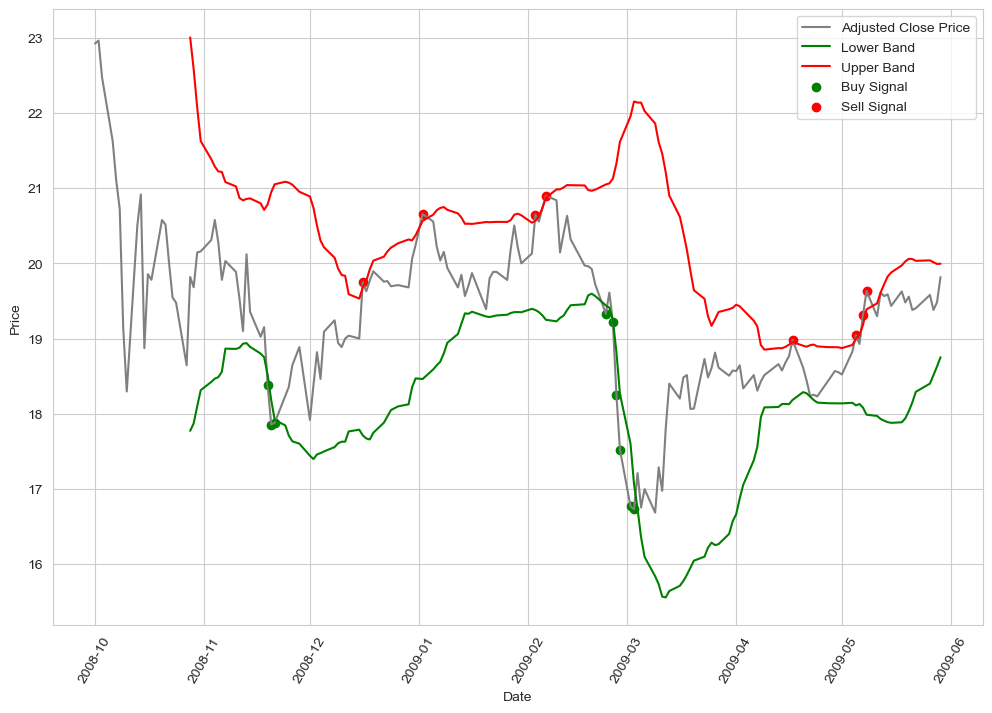

In [125]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['trough']['XLV'])

This graph shows the movement of the healthcare sector ETF (XLV) during a trough. The buy signals are bought when the stock is locally moving down where as the stock is sold when the stock is moving up locally. There are 9 buy signals and 8 sell signals.

## Stochastic Modeling for Bollinger Bands
Stochastic modeling is going to be slightly different. There needs to be 2 dataframes associated with the investment. There needs to a signal dataframe and the adjusted close price dataframe. The signal dataframe is the different tickers signal for each day meanwhile the adjusted close price is the dataframe with the closing adjusted price for each ticker. When there is a signal to buy or sell you need to get the adjusted close price data from the other dataframe in order to update the investment.

In [126]:
# get the adjusted close price dataframe
sector_etf_closed_price = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [127]:
# load in the dataframe for the trough time period
sector_etf_closed_price['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119270,21.858328,12.413447,15.649682,22.589596,18.009499,37.393242,22.927490,36.648037,18.666508,34.011742
2008-10-02,21.458338,20.549885,11.794873,15.037057,21.771833,17.782770,35.261108,22.965389,35.561867,18.395739,31.759169
2008-10-03,21.247202,20.222782,11.278399,14.822244,21.010757,17.640244,34.840706,22.472731,35.039394,18.119308,30.064156
2008-10-06,20.198565,19.692131,10.689857,14.002769,20.419699,17.128458,32.966846,21.631424,33.396393,17.233658,29.512161
2008-10-07,19.156967,19.037897,9.560812,13.286716,19.108055,16.584286,31.159042,21.108448,31.966497,16.528513,27.019812
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848717,16.073524,7.178292,13.618086,18.520382,15.070186,29.497364,19.404516,33.037392,14.918156,18.541615
2009-05-26,19.300224,16.658962,7.412232,13.971801,19.143744,15.260780,30.122379,19.580988,34.221859,15.351315,19.500559
2009-05-27,18.576372,16.117985,7.190604,13.835133,18.725449,14.873019,29.794704,19.381496,33.881424,15.039448,18.851515


In [128]:
# get the signals for tickers
bb_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [149]:
for period in economic_cycle_periods_list:
    bb_signals[period].to_csv(f'/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/signal_data/bollinger_bands/{period}_bollinger_band_signals.csv')

In [129]:
# get the bollinger band signals for trough
# nan represent no purchase or sell (hold)
bb_signals['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-05-26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-05-27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [130]:
# ensure that the dataframe has buy and sell signals
bb_signals['trough']['XLV'].value_counts()

nan     149
Buy       9
Sell      8
Name: XLV, dtype: int64

### Bollinger Band Investment
Using Bollinger Bands look at different economic time periods and look at how each sector ETF performs. Each stock is given $100 and will be tracked individually, the overall portfolio will be worked on later.

In [131]:
# track the return when doing a single simulation
bollinger_band_return = individual_stock(bb_signals,sector_etf_closed_price,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,100,0.05,0.05)

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_8765/2346950938.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_tracker = stock_tracker.append({
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_8765/2346950938.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_tracker = stock_tracker.append({
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_8765/2346950938.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_tracker = stock_tracker.append({
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_8765/2346950938.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_tracke

In [132]:
# an example of portfolio tracking during a trough time period
bollinger_band_return['Stock Tracker']['trough']['XLV']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership,Account Balance,Stock Value ($),Total Value ($),Profit ($)
0,2009-01-20,19.391684,Hold,0.0,0.0,0.000000,0.000000,100.00000,0.000000,100.000000,0.000000
1,2009-01-21,19.803453,Hold,0.0,0.0,0.000000,0.000000,100.00000,0.000000,100.000000,0.000000
2,2009-01-22,19.887337,Hold,0.0,0.0,0.000000,0.000000,100.00000,0.000000,100.000000,0.000000
3,2009-01-23,19.887337,Hold,0.0,0.0,0.000000,0.000000,100.00000,0.000000,100.000000,0.000000
4,2009-01-26,19.780586,Hold,0.0,0.0,0.000000,0.000000,100.00000,0.000000,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
76,2009-05-12,19.611679,Hold,0.0,0.0,23.510020,1.198776,78.75889,23.510020,102.268910,2.268910
77,2009-05-13,19.565641,Hold,0.0,0.0,23.454831,1.198776,78.75889,23.454831,102.213721,2.213721
78,2009-05-14,19.588661,Hold,0.0,0.0,23.482427,1.198776,78.75889,23.482427,102.241317,2.241317
79,2009-05-15,19.435207,Hold,0.0,0.0,23.298470,1.198776,78.75889,23.298470,102.057360,2.057360


### Stochastic Modeling
The above only concentrated on a single set of investment dates, to get the average returns to understand how bollinger bands actually perform, it is neccessary to rereun the simulation thousands of times so that the effects of standard deviation are reduced.

In [133]:
# stochastic model 1000 times with a $100 investment of the stock
bb_average_return = calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,100,0.05,0.05)

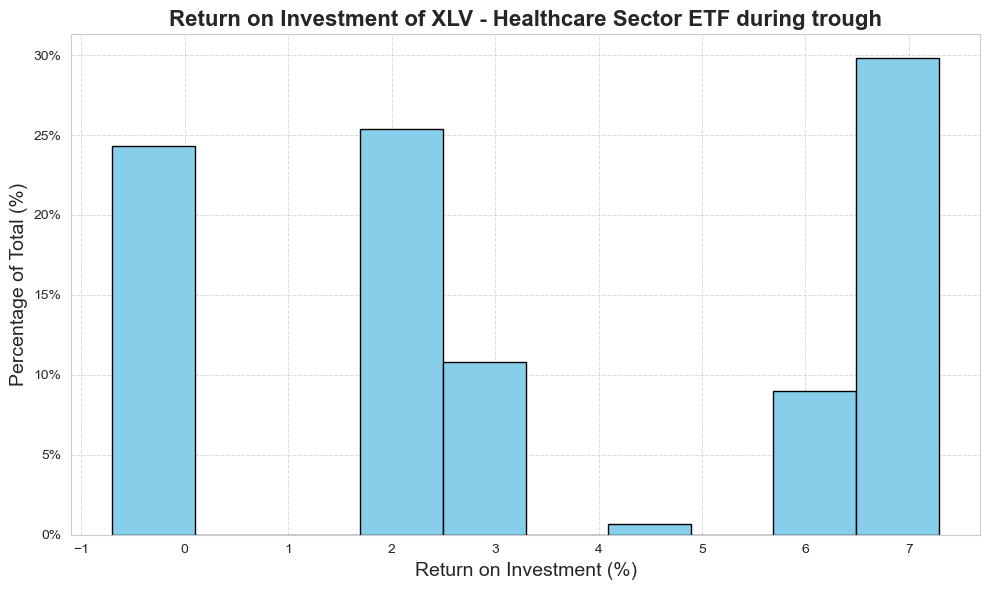

In [134]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

In [135]:
# get the mean of each stock during each time period
bollinger_band_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Mean')
bollinger_band_average_return

,trough,expansion,peak,contraction,all_data
XLB,0.111376,2.909002,7.766656,5.470918,4.047584
XLI,5.913364,4.578448,6.400588,-2.387284,3.252669
XLF,-2.508753,3.047783,8.08417,-2.46039,2.737841
XLK,1.156225,4.052004,4.975443,2.767964,3.557677
XLY,5.542987,3.961424,13.285349,4.977997,3.977765
XLP,0.899896,2.958756,0.487697,4.634063,3.387138
XLE,4.221545,4.733001,8.942925,2.933318,4.492614
XLV,3.277763,2.715801,2.964604,7.092937,4.140228
VOX,4.667345,5.070946,4.56191,4.709325,4.077543
XLU,1.003137,4.014553,2.164693,2.628947,3.609534


In [143]:
# save file
bollinger_band_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/bollinger_band_return.csv')

In [136]:
# import buy and hold data
benchmark_buy_hold = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/buy_hold_average_return.csv')
benchmark_buy_hold.set_index('Unnamed: 0', inplace=True)
benchmark_buy_hold.index.name=None
benchmark_buy_hold

,trough,expansion,peak,contraction,all_data
XLB,3.900911,7.191447,4.863190,-0.879949,5.065171
XLI,-8.878958,9.078559,8.266920,-6.448493,5.767748
XLF,-18.992435,10.304957,11.545884,-20.347092,3.919354
XLK,7.403683,7.835554,17.154843,-4.478001,7.754997
XLY,7.091644,9.879945,4.622176,-5.922727,6.349472
XLP,-6.910654,7.805316,7.674492,0.590655,4.956760
XLE,-2.052398,5.583414,-1.389255,3.765992,4.241143
XLV,-4.098441,12.546292,11.667412,-5.143992,5.564693
VOX,10.851312,7.534924,8.610913,-7.733939,4.569639
XLU,-7.357008,6.301877,8.854666,-3.884052,4.539563


In [137]:
# compare the performance
performance_against_benchmark_return = bollinger_band_average_return - benchmark_buy_hold
performance_against_benchmark_return

,trough,expansion,peak,contraction,all_data
XLB,-3.789534,-4.282445,2.903466,6.350867,-1.017587
XLI,14.792322,-4.500111,-1.866332,4.061209,-2.515079
XLF,16.483682,-7.257174,-3.461715,17.886702,-1.181513
XLK,-6.247459,-3.78355,-12.1794,7.245965,-4.19732
XLY,-1.548657,-5.918521,8.663173,10.900725,-2.371707
XLP,7.81055,-4.84656,-7.186795,4.043408,-1.569622
XLE,6.273943,-0.850413,10.33218,-0.832674,0.251472
XLV,7.376204,-9.830491,-8.702808,12.236928,-1.424466
VOX,-6.183968,-2.463977,-4.049003,12.443263,-0.492096
XLU,8.360145,-2.287324,-6.689973,6.512999,-0.930029


In [138]:
# compare the performance
performance_against_benchmark_return.mean()

trough         5.541698
expansion     -4.541510
peak          -2.468543
contraction    7.665193
all_data      -1.453106
dtype: float64

During times of worse economic periods the bollinger bands perform better. It is likely that when the economy is going down the going in and out at certain momentums performs better than the simple buy and hold as the entire market is decreasing.

In [139]:
bollinger_band_std = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Std')
bollinger_band_std

,trough,expansion,peak,contraction,all_data
XLB,1.283467,6.456253,2.358527,2.495865,5.42036
XLI,2.202148,6.470341,3.115012,0.651237,4.69401
XLF,13.464279,3.191672,1.192002,6.760415,4.991184
XLK,0.780706,5.423236,1.586552,2.729231,4.960741
XLY,1.37613,4.969036,4.58184,3.077592,4.848282
XLP,4.786051,5.142623,1.83353,3.595799,4.464258
XLE,1.406582,4.689778,4.240839,3.470724,6.193966
XLV,2.995523,3.268512,2.212828,3.354844,5.004102
VOX,1.768037,5.701796,1.856672,3.263644,5.323558
XLU,2.617063,5.150747,3.251147,2.955486,4.781067


In [145]:
# save the bollinger band standard deviation
bollinger_band_std.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/bollinger_band_std.csv')

In [140]:
benchmark_std = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/buy_hold_standard_deviation.csv')
benchmark_std.set_index('Unnamed: 0',inplace=True)
benchmark_std.index.name = None
benchmark_std

,trough,expansion,peak,contraction,all_data
XLB,17.277460,5.816821,1.625479,7.179044,14.057962
XLI,12.414065,6.478260,1.944622,4.256538,13.442710
XLF,21.660012,6.269850,1.479566,5.094421,17.127427
XLK,11.629640,4.621631,3.689527,5.153776,12.710283
XLY,16.036022,5.926743,2.011304,3.955491,13.135228
XLP,6.313260,4.106937,1.396014,3.585570,7.164913
XLE,11.410343,8.339108,1.581173,10.446025,18.233348
XLV,7.670385,4.471472,2.317246,6.613368,8.862318
VOX,10.844260,5.010314,2.171424,5.928108,12.441252
XLU,5.324031,5.669811,3.503517,4.008002,8.995880


In [141]:
# compare the risk between the two
performance_against_benchmark_std = bollinger_band_std - benchmark_std
performance_against_benchmark_std

,trough,expansion,peak,contraction,all_data
XLB,-15.993993,0.639432,0.733048,-4.683179,-8.637602
XLI,-10.211917,-0.007919,1.17039,-3.6053,-8.748699
XLF,-8.195733,-3.078178,-0.287564,1.665993,-12.136242
XLK,-10.848935,0.801605,-2.102975,-2.424545,-7.749542
XLY,-14.659892,-0.957706,2.570537,-0.877898,-8.286946
XLP,-1.527209,1.035687,0.437516,0.010229,-2.700655
XLE,-10.003761,-3.649329,2.659665,-6.975301,-12.039382
XLV,-4.674862,-1.20296,-0.104418,-3.258523,-3.858215
VOX,-9.076223,0.691482,-0.314751,-2.664464,-7.117693
XLU,-2.706968,-0.519064,-0.252371,-1.052516,-4.214813


In [142]:
# look at the risk in investment
performance_against_benchmark_std.mean()

trough        -9.310937
expansion     -0.937721
peak           0.511714
contraction   -2.259636
all_data      -7.748069
dtype: float64

Overall the bollinger bands perform better during times of troughs and contractions but are much riskier than the standard buy and hold strategy.